In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from f1tenth_gym_jax import make
import jax
import jax.numpy as jnp

# jax.config.update("jax_debug_nans", True)

from f1tenth_gym_jax.envs.utils import Param

In [2]:
num_agents = 10
num_envs = 100

In [3]:
env = make(f"Spielberg_{num_agents}_noscan_time_v0")

In [4]:
rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
reset_rng = jax.random.split(_rng, num_envs)

In [5]:
import chex
chex.clear_trace_counter()

In [6]:
obsv, env_state = jax.vmap(env.reset)(reset_rng)

/home/billyzheng/.cache/pypoetry/virtualenvs/f1tenth-gym-jax-3S11c-Oo-py3.13/lib/python3.13/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/home/billyzheng/.cache/pypoetry/virtualenvs/f1tenth-gym-jax-3S11c-Oo-py3.13/lib/python3.13/site-packages/jax/_src/numpy/array_creation.py:532: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  delta: Array = lax.convert_element_type(s

In [7]:
rng, _rng = jax.random.split(rng)
action_rng = jax.random.split(_rng, num_envs*num_agents).reshape((num_agents, num_envs, -1))
actions = {k: jax.vmap(env.action_space(k).sample)(action_rng[i]) for i, k in enumerate(env.agents)}

In [8]:
rng, _rng = jax.random.split(rng)
step_rng = jax.random.split(_rng, num_envs)
obsv, env_state, _, _, info = jax.vmap(env.step)(step_rng, env_state, actions)

In [9]:
def env_init(rng):
    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, num_envs)
    obsv, env_state = jax.vmap(env.reset)(reset_rng)
    return (env_state, obsv, rng)

In [10]:
def env_step(runner_state, unused):
    env_state, last_obs, rng = runner_state

    rng, _rng = jax.random.split(rng)
    action_rng = jax.random.split(_rng, num_envs*num_agents).reshape((num_agents, num_envs, -1))
    actions = {k: jax.vmap(env.action_space(k).sample)(action_rng[i]) for i, k in enumerate(env.agents)}

    rng, _rng = jax.random.split(rng)
    step_rng = jax.random.split(_rng, num_envs)
    obsv, env_state, _, _, info = jax.vmap(env.step)(step_rng, env_state, actions)

    runner_state = (env_state, obsv, rng)
    return runner_state, None

In [11]:
import time

In [19]:
tick = time.time()
for _ in range(100):
    runner_state = env_init(rng)
    runner_state = jax.lax.scan(env_step, runner_state, None, length=100)
tock = time.time()

In [20]:
sps = 100 * 100 * num_envs / (tock - tick)

In [21]:
sps

389312.88286272186

In [15]:
env_states_all = runner_state[0]

In [16]:
env_states_all[0].cartesian_states.shape

(100, 10, 7)

In [17]:
env_states_all[0].cartesian_states[100, :, :]

Array([[-4.47607460e+01,  5.96546221e+00,  4.16736491e-03,
         9.29239690e-01,  1.35691687e-02,  1.13936812e-02,
         2.16382928e-03],
       [-4.57358360e+01,  7.20031309e+00,  1.52352184e-01,
        -3.66084665e-01,  7.18892505e-03,  5.78520708e-02,
         7.95554668e-02],
       [-4.63223343e+01,  7.58925056e+00, -3.18057597e-01,
        -7.71217644e-01, -7.43347045e-04,  7.21947372e-01,
        -1.69249579e-01],
       [-4.67839165e+01,  8.85327530e+00,  3.83552045e-01,
         6.31313205e-01,  1.13422282e-01,  7.83432782e-01,
         2.06530556e-01],
       [-4.73457489e+01,  9.21814823e+00, -2.10523978e-01,
         2.81351954e-01, -3.37884538e-02, -1.87121302e-01,
        -1.10502593e-01],
       [-4.80264587e+01,  1.04817619e+01,  3.07539195e-01,
        -5.47583461e-01,  1.06744992e-03, -2.48607427e-01,
         1.63349226e-01],
       [-4.82747955e+01,  1.08801117e+01, -2.34946996e-01,
         7.81077147e-01, -1.17579065e-01, -5.45244932e-01,
        -1.2365295

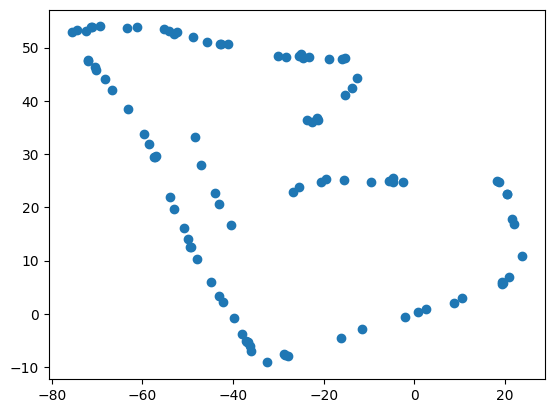

In [18]:
import matplotlib.pyplot as plt
plt.plot(env_states_all[0].cartesian_states[:, 0, 0], env_states_all[0].cartesian_states[:, 0, 1], 'o')